In [12]:
import sys

import darkdetect
import gmsh
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg
from matplotlib import pyplot as plt

from examples.gen_unit_square import gen_unit_square
from fem.matrix import mass_matrix
from fem.matrix.load_vector import load_node
from fem.matrix.mass_matrix import mass_node
from fem.matrix.stiffness_matrix import stiffness_node
from fem.mesh.mesh_2d import make_mesh
from fem.plot.plot_mesh import plot_mesh
from fem.plot.plot_pot import plot_pot
from util.gmsh_model import gmsh_model

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
## matplotlib settings
if darkdetect.isDark():
    plt.style.use('dark_background')
else:
    plt.style.use('default')

plt.rcParams.update({
    "text.usetex": True
})

## Setup problem
### 1) Mesh generation of $\Omega = (0,1)^2$

In [14]:
sys.argv.append('-nopopup')
gen_unit_square()
msh = make_mesh()

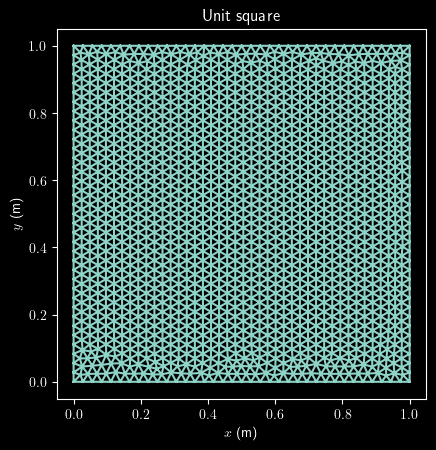

In [15]:
plot_mesh(msh, title='Unit square')

### 2) Right hand side 
#### $f = (2 \pi^2 + 1) \cos(\pi x) \cos(\pi y)$

In [16]:
def u_ana(p: np.ndarray) -> np.ndarray | float:
    return np.cos(np.pi*p[0])*np.cos(np.pi*p[1])

def f(p: np.ndarray):
    return (2*np.pi**2 + 1)*u_ana(p)

b = load_node(msh, f, 3)

### 3) Matrix assembly

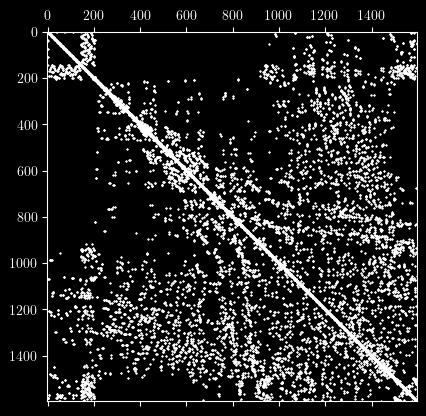

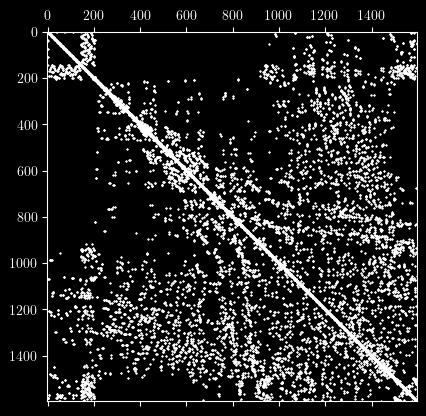

In [17]:
K = stiffness_node(msh)
M = mass_node(msh)
plt.figure()
plt.spy(K, markersize=.5)
plt.figure()
plt.spy(M, markersize=.5)

## Solution
### 1) Solve system 
#### $ \begin{align*}
-\Delta u + u &= f \quad \text{in}\, \Omega \\
\partial_n u &= 0 \quad \text{on}\, \partial\Omega
\end{align*} $

In [18]:
u_h, info = sp.linalg.gmres(K + M, b)
print(f"gmres terminated with exit code {info}")

gmres terminated with exit code 0


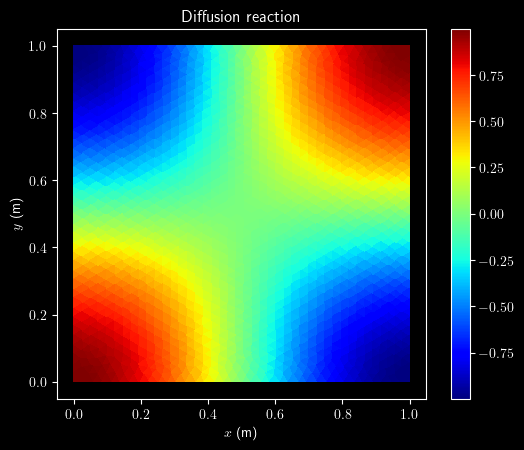

In [19]:
plot_pot(msh, u_h, title=r'Diffusion reaction', cmap='jet')

### 2) Calculate L2 error
#### $ ||u_h - I_h^0 u ||_2^2 
    = ||\mathbf{u}_h - \mathbf{u}||_{\mathbf{M}} 
    = (\mathbf{u}_h - \mathbf{u})^\top \mathbf{M} (\mathbf{u}_h - \mathbf{u}) $

In [20]:
u = u_ana(msh.nodes.T)
err = (u_h - u).T @ M @ (u_h - u)
print(f"L2 error between numerical and analytical solution = {err}")

L2 error between numerical and analytical solution = 1.116554358141672e-08
